In [1]:
import pandas as pd
import numpy as np
from numpy.random import normal, seed

import matplotlib.pyplot as plt
from pylab import rcParams

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

import math
from sklearn.metrics import mean_squared_error

## Read Data

In [2]:
google = pd.read_csv('Stock/GOOGL_2006-01-01_to_2018-01-01.csv',
                     index_col='Date', parse_dates=['Date'])

google.head()

Open    High     Low   Close    Volume   Name
Date                                                       
2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL
2006-01-05  223.22  226.00  220.97  225.85  10815661  GOOGL
2006-01-06  228.66  235.49  226.85  233.06  17759521  GOOGL
2006-01-09  233.44  236.94  230.70  233.68  12795837  GOOGL

In [3]:
humidity = pd.read_csv('Weather/humidity.csv', index_col='datetime', parse_dates=['datetime'])
humidity.tail()

Vancouver  Portland  San Francisco  Seattle  Los Angeles  \
datetime                                                                        
2017-11-29 20:00:00        NaN      81.0            NaN     93.0         24.0   
2017-11-29 21:00:00        NaN      71.0            NaN     87.0         21.0   
2017-11-29 22:00:00        NaN      71.0            NaN     93.0         23.0   
2017-11-29 23:00:00        NaN      71.0            NaN     87.0         14.0   
2017-11-30 00:00:00        NaN      76.0            NaN     75.0         56.0   

                     San Diego  Las Vegas  Phoenix  Albuquerque  Denver  ...  \
datetime                                                                 ...   
2017-11-29 20:00:00       72.0       18.0     68.0         37.0    18.0  ...   
2017-11-29 21:00:00       72.0       18.0     73.0         34.0    12.0  ...   
2017-11-29 22:00:00       68.0       17.0     60.0         32.0    15.0  ...   
2017-11-29 23:00:00       63.0       17.0     33.0         30.0    28.0  ...   
2017-11-30 00:00:00       72.0       17.0     23.0         34.0    31.0  ...   

                     Philadelphia  New York  Montreal  Boston  Beersheba  \
datetime                                                                   
2017-11-29 20:00:00          27.0       NaN      64.0    37.0        NaN   
2017-11-29 21:00:00          29.0       NaN      59.0    74.0        NaN   
2017-11-29 22:00:00          31.0       NaN      66.0    74.0        NaN   
2017-11-29 23:00:00          26.0       NaN      58.0    56.0        NaN   
2017-11-30 00:00:00          32.0       NaN      58.0    56.0        NaN   

                     Tel Aviv District  Eilat  Haifa  Nahariyya  Jerusalem  
datetime                                                                    
2017-11-29 20:00:00                NaN    NaN    NaN        NaN        NaN  
2017-11-29 21:00:00                NaN    NaN    NaN        NaN        NaN  
2017-11-29 22:00:00                NaN    NaN    NaN        NaN        NaN  
2017-11-29 23:00:00                NaN    NaN    NaN        NaN        NaN  
2017-11-30 00:00:00                NaN    NaN    NaN        NaN        NaN  

[5 rows x 36 columns]

## Clean Data

In [4]:
google_empty = len(google[google.isnull().any(axis=1)])
print(f'GOOGLE have {google_empty} rows with empty values')

GOOGLE have 0 rows with empty values


In [5]:
humidity_empty = len(humidity[humidity.isnull().any(axis=1)])
print(f'Humidity have {humidity_empty} rows with empty values')

Humidity have 8990 rows with empty values


In [6]:
humidity = humidity.iloc[1:]
humidity = humidity.ffill()
humidity.tail()

Vancouver  Portland  San Francisco  Seattle  Los Angeles  \
datetime                                                                        
2017-11-29 20:00:00       87.0      81.0           22.0     93.0         24.0   
2017-11-29 21:00:00       87.0      71.0           22.0     87.0         21.0   
2017-11-29 22:00:00       87.0      71.0           22.0     93.0         23.0   
2017-11-29 23:00:00       87.0      71.0           22.0     87.0         14.0   
2017-11-30 00:00:00       87.0      76.0           22.0     75.0         56.0   

                     San Diego  Las Vegas  Phoenix  Albuquerque  Denver  ...  \
datetime                                                                 ...   
2017-11-29 20:00:00       72.0       18.0     68.0         37.0    18.0  ...   
2017-11-29 21:00:00       72.0       18.0     73.0         34.0    12.0  ...   
2017-11-29 22:00:00       68.0       17.0     60.0         32.0    15.0  ...   
2017-11-29 23:00:00       63.0       17.0     33.0         30.0    28.0  ...   
2017-11-30 00:00:00       72.0       17.0     23.0         34.0    31.0  ...   

                     Philadelphia  New York  Montreal  Boston  Beersheba  \
datetime                                                                   
2017-11-29 20:00:00          27.0      58.0      64.0    37.0       57.0   
2017-11-29 21:00:00          29.0      58.0      59.0    74.0       57.0   
2017-11-29 22:00:00          31.0      58.0      66.0    74.0       57.0   
2017-11-29 23:00:00          26.0      58.0      58.0    56.0       57.0   
2017-11-30 00:00:00          32.0      58.0      58.0    56.0       57.0   

                     Tel Aviv District  Eilat  Haifa  Nahariyya  Jerusalem  
datetime                                                                    
2017-11-29 20:00:00               60.0  100.0   96.0       96.0       60.0  
2017-11-29 21:00:00               60.0  100.0   96.0       96.0       60.0  
2017-11-29 22:00:00               60.0  100.0   96.0       96.0       60.0  
2017-11-29 23:00:00               60.0  100.0   96.0       96.0       60.0  
2017-11-30 00:00:00               60.0  100.0   96.0       96.0       60.0  

[5 rows x 36 columns]

In [7]:
humidity_empty = len(humidity[humidity.isnull().any(axis=1)])
print(f'Humidity have {humidity_empty} rows with empty values')

Humidity have 0 rows with empty values


## Visualisation

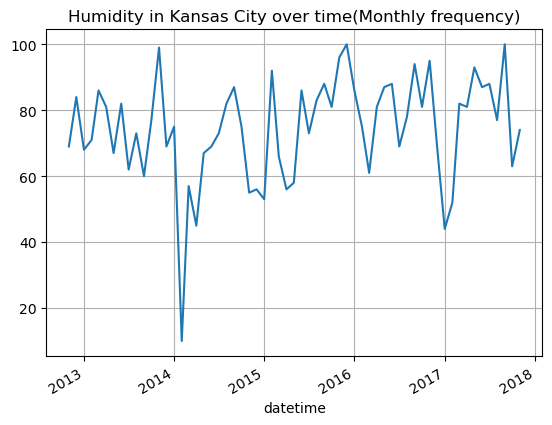

In [8]:
humidity['Kansas City'].asfreq('ME').plot()

plt.title('Humidity in Kansas City over time(Monthly frequency)')
plt.grid()
plt.show()

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

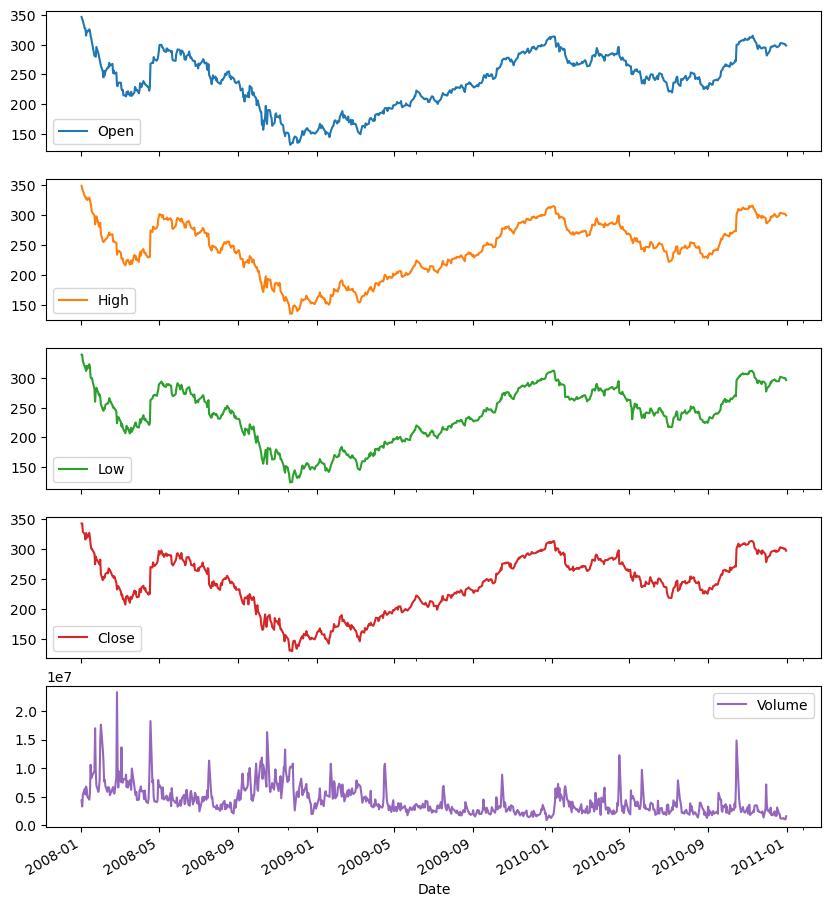

In [9]:
google['2008':'2010'].plot(subplots=True, figsize = (10, 12))

## Timestamps and Periods

In [10]:
timestamp = pd.Timestamp(2017, 1, 1, 12) # y/m/d
timestamp

Timestamp('2017-01-01 12:00:00')

In [11]:
period = pd.Period('2017-01-01') # y/m/d
period

Period('2017-01-01', 'D')

In [12]:
period.start_time < timestamp < period.end_time

True

In [13]:
new_period = timestamp.to_period(freq='h')
new_period

Period('2017-01-01 12:00', 'h')

In [14]:
new_timestamp = period.to_timestamp(freq='h', how='S')
new_timestamp

Timestamp('2017-01-01 00:00:00')

## Using date_range

In [15]:
dr1 = pd.date_range(start='1/1/18', end='1/9/18') # m/d/y
dr1

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09'],
              dtype='datetime64[ns]', freq='D')

In [16]:
dr2 = pd.date_range(start='1/1/18', end='1/1/19', freq='ME')
dr2

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='ME')

In [17]:
dr3 = pd.date_range(end='1/4/2014', periods=8)
dr3

DatetimeIndex(['2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31',
               '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04'],
              dtype='datetime64[ns]', freq='D')

In [18]:
dr4 = pd.date_range(start='2013-04-24', end='2014-11-27', periods=3)
dr4

DatetimeIndex(['2013-04-24', '2014-02-09', '2014-11-27'], dtype='datetime64[ns]', freq=None)

## Using to_datetime

In [19]:
df = pd.DataFrame({'year': [2015, 2016], 'month': [2, 3], 'day': [4, 5]})
df

year  month  day
0  2015      2    4
1  2016      3    5

In [20]:
df = pd.to_datetime(df)
df

0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]

In [21]:
df = pd.to_datetime('01-01-2017')
df

Timestamp('2017-01-01 00:00:00')

## Shifting and lags

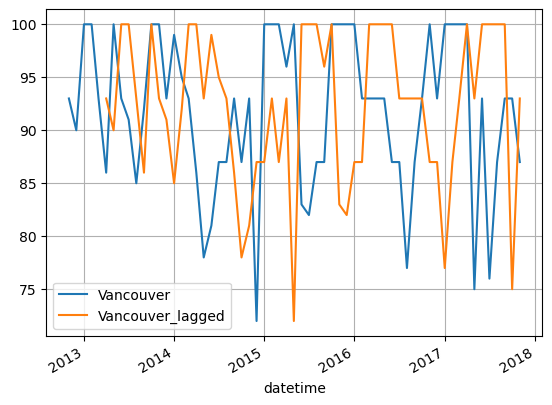

In [22]:
humidity["Vancouver"].asfreq('ME').plot(legend=True)
humidity["Vancouver"].asfreq('ME').shift(5).plot(legend=True)
plt.legend(['Vancouver', 'Vancouver_lagged'])
plt.grid()
plt.show()

## Resampling

**Upsampling** = Time series is resampled from low frequency to high frequency (Monthly to daily frequency). It involves filling or interpolating missing data.

```python
dates = pd.date_range(start='2021-01-01', periods=6, freq='M')
data = [1, 3, 2, 5, 4, 6]
df = pd.DataFrame(data, index=dates, columns=['value'])

#Upsampling to daily frequency
df_daily = df.resample('D').interpolate()
df_daily
```

**Downsampling** = Time series is resampled from high frequency to low frequency (Weekly to monthly frequency). It involved aggregation of existing data.

In [23]:
pressure = pd.read_csv('Weather/pressure.csv', index_col='datetime', parse_dates=['datetime'])
pressure.head()

Vancouver  Portland  San Francisco  Seattle  Los Angeles  \
datetime                                                                        
2012-10-01 12:00:00        NaN       NaN            NaN      NaN          NaN   
2012-10-01 13:00:00        NaN    1024.0         1009.0   1027.0       1013.0   
2012-10-01 14:00:00        NaN    1024.0         1009.0   1027.0       1013.0   
2012-10-01 15:00:00        NaN    1024.0         1009.0   1028.0       1013.0   
2012-10-01 16:00:00        NaN    1024.0         1009.0   1028.0       1013.0   

                     San Diego  Las Vegas  Phoenix  Albuquerque  Denver  ...  \
datetime                                                                 ...   
2012-10-01 12:00:00        NaN        NaN      NaN          NaN     NaN  ...   
2012-10-01 13:00:00     1013.0     1018.0   1013.0       1024.0  1028.0  ...   
2012-10-01 14:00:00     1013.0     1018.0   1013.0       1024.0  1028.0  ...   
2012-10-01 15:00:00     1013.0     1018.0   1013.0       1024.0  1028.0  ...   
2012-10-01 16:00:00     1013.0     1018.0   1013.0       1024.0  1028.0  ...   

                     Philadelphia  New York  Montreal  Boston  Beersheba  \
datetime                                                                   
2012-10-01 12:00:00           NaN       NaN       NaN     NaN        NaN   
2012-10-01 13:00:00        1014.0    1012.0    1001.0  1014.0      984.0   
2012-10-01 14:00:00        1014.0    1012.0     986.0  1014.0      984.0   
2012-10-01 15:00:00        1014.0    1012.0     945.0  1014.0      984.0   
2012-10-01 16:00:00        1014.0    1012.0     904.0  1014.0      984.0   

                     Tel Aviv District   Eilat   Haifa  Nahariyya  Jerusalem  
datetime                                                                      
2012-10-01 12:00:00                NaN  1011.0     NaN        NaN        NaN  
2012-10-01 13:00:00             1012.0  1010.0  1013.0     1013.0      990.0  
2012-10-01 14:00:00             1012.0  1010.0  1013.0     1013.0      990.0  
2012-10-01 15:00:00             1012.0  1010.0  1013.0     1013.0      990.0  
2012-10-01 16:00:00             1012.0  1010.0  1013.0     1013.0      990.0  

[5 rows x 36 columns]

In [24]:
pressure = pressure[1:]
pressure = pressure.ffill()
pressure.tail()

Vancouver  Portland  San Francisco  Seattle  Los Angeles  \
datetime                                                                        
2017-11-29 20:00:00     1021.0    1031.0         1013.0   1030.0       1016.0   
2017-11-29 21:00:00     1021.0    1030.0         1013.0   1030.0       1016.0   
2017-11-29 22:00:00     1021.0    1030.0         1013.0   1029.0       1015.0   
2017-11-29 23:00:00     1021.0    1029.0         1013.0   1028.0       1016.0   
2017-11-30 00:00:00     1021.0    1029.0         1013.0   1028.0       1015.0   

                     San Diego  Las Vegas  Phoenix  Albuquerque  Denver  ...  \
datetime                                                                 ...   
2017-11-29 20:00:00     1017.0     1021.0   1018.0       1025.0  1016.0  ...   
2017-11-29 21:00:00     1017.0     1020.0   1018.0       1024.0  1018.0  ...   
2017-11-29 22:00:00     1016.0     1020.0   1017.0       1024.0  1018.0  ...   
2017-11-29 23:00:00     1016.0     1020.0   1016.0       1024.0  1020.0  ...   
2017-11-30 00:00:00     1017.0     1019.0   1016.0       1024.0  1021.0  ...   

                     Philadelphia  New York  Montreal  Boston  Beersheba  \
datetime                                                                   
2017-11-29 20:00:00        1021.0    1020.0    1021.0  1017.0      984.0   
2017-11-29 21:00:00        1021.0    1020.0    1023.0  1019.0      984.0   
2017-11-29 22:00:00        1022.0    1020.0    1024.0  1019.0      984.0   
2017-11-29 23:00:00        1023.0    1020.0    1026.0  1022.0      984.0   
2017-11-30 00:00:00        1024.0    1020.0    1027.0  1023.0      984.0   

                     Tel Aviv District  Eilat   Haifa  Nahariyya  Jerusalem  
datetime                                                                     
2017-11-29 20:00:00             1011.0  968.0  1023.0     1023.0     1011.0  
2017-11-29 21:00:00             1011.0  968.0  1023.0     1023.0     1011.0  
2017-11-29 22:00:00             1011.0  968.0  1023.0     1023.0     1011.0  
2017-11-29 23:00:00             1011.0  968.0  1023.0     1023.0     1011.0  
2017-11-30 00:00:00             1011.0  968.0  1023.0     1023.0     1011.0  

[5 rows x 36 columns]

In [25]:
pressure = pressure.bfill()
pressure.head()

Vancouver  Portland  San Francisco  Seattle  Los Angeles  \
datetime                                                                        
2012-10-01 13:00:00      807.0    1024.0         1009.0   1027.0       1013.0   
2012-10-01 14:00:00      807.0    1024.0         1009.0   1027.0       1013.0   
2012-10-01 15:00:00      807.0    1024.0         1009.0   1028.0       1013.0   
2012-10-01 16:00:00      807.0    1024.0         1009.0   1028.0       1013.0   
2012-10-01 17:00:00      807.0    1024.0         1009.0   1029.0       1013.0   

                     San Diego  Las Vegas  Phoenix  Albuquerque  Denver  ...  \
datetime                                                                 ...   
2012-10-01 13:00:00     1013.0     1018.0   1013.0       1024.0  1028.0  ...   
2012-10-01 14:00:00     1013.0     1018.0   1013.0       1024.0  1028.0  ...   
2012-10-01 15:00:00     1013.0     1018.0   1013.0       1024.0  1028.0  ...   
2012-10-01 16:00:00     1013.0     1018.0   1013.0       1024.0  1028.0  ...   
2012-10-01 17:00:00     1013.0     1018.0   1013.0       1024.0  1028.0  ...   

                     Philadelphia  New York  Montreal  Boston  Beersheba  \
datetime                                                                   
2012-10-01 13:00:00        1014.0    1012.0    1001.0  1014.0      984.0   
2012-10-01 14:00:00        1014.0    1012.0     986.0  1014.0      984.0   
2012-10-01 15:00:00        1014.0    1012.0     945.0  1014.0      984.0   
2012-10-01 16:00:00        1014.0    1012.0     904.0  1014.0      984.0   
2012-10-01 17:00:00        1014.0    1012.0     863.0  1014.0      984.0   

                     Tel Aviv District   Eilat   Haifa  Nahariyya  Jerusalem  
datetime                                                                      
2012-10-01 13:00:00             1012.0  1010.0  1013.0     1013.0      990.0  
2012-10-01 14:00:00             1012.0  1010.0  1013.0     1013.0      990.0  
2012-10-01 15:00:00             1012.0  1010.0  1013.0     1013.0      990.0  
2012-10-01 16:00:00             1012.0  1010.0  1013.0     1013.0      990.0  
2012-10-01 17:00:00             1012.0  1010.0  1013.0     1013.0      990.0  

[5 rows x 36 columns]

In [26]:
pressure.shape

(45252, 36)

### downsampling

In [27]:
pressure = pressure.resample('3D').mean()
pressure.head()

Vancouver     Portland  San Francisco      Seattle  Los Angeles  \
datetime                                                                        
2012-10-01   931.627119  1022.644068    1010.881356  1031.271186  1011.627119   
2012-10-04  1019.083333  1023.041667    1014.694444  1028.305556  1015.555556   
2012-10-07  1013.930556  1017.444444    1016.597222  1018.736111  1013.416667   
2012-10-10  1015.000000  1015.430556    1014.833333  1018.416667  1010.694444   
2012-10-13  1008.152778  1018.111111    1021.069444  1015.930556  1017.277778   

              San Diego    Las Vegas      Phoenix  Albuquerque       Denver  \
datetime                                                                      
2012-10-01  1011.966102  1016.322034  1012.084746  1022.542373  1024.118644   
2012-10-04  1016.277778  1013.194444  1014.097222  1019.972222  1020.666667   
2012-10-07  1014.222222  1012.888889  1011.861111  1005.833333  1020.458333   
2012-10-10  1014.013889  1000.166667  1005.611111   986.000000   984.486111   
2012-10-13  1018.375000  1015.666667  1015.500000  1013.625000  1010.444444   

            ...  Philadelphia     New York     Montreal       Boston  \
datetime    ...                                                        
2012-10-01  ...   1014.152542  1013.423729   937.627119  1013.677966   
2012-10-04  ...   1018.097222  1017.680556  1017.180556  1019.805556   
2012-10-07  ...   1017.958333  1016.750000  1014.152778  1016.305556   
2012-10-10  ...   1018.694444  1017.916667  1016.166667  1017.319444   
2012-10-13  ...   1025.055556  1024.388889  1020.805556  1023.736111   

             Beersheba  Tel Aviv District        Eilat        Haifa  \
datetime                                                              
2012-10-01  985.050847        1012.949153  1011.796610  1013.000000   
2012-10-04  984.930556        1013.083333  1012.611111  1013.000000   
2012-10-07  982.972222        1013.027778  1007.555556  1013.000000   
2012-10-10  979.763889        1006.527778   998.763889  1012.333333   
2012-10-13  984.527778        1013.027778  1007.194444  1013.000000   

              Nahariyya   Jerusalem  
datetime                             
2012-10-01  1013.000000  990.525424  
2012-10-04  1013.000000  990.083333  
2012-10-07  1013.000000  989.833333  
2012-10-10  1012.333333  987.888889  
2012-10-13  1013.000000  990.430556  

[5 rows x 36 columns]

In [28]:
pressure.shape

(629, 36)

### upsampling

In [29]:
pressure = pressure.resample('D').ffill()
pressure.head()

Vancouver     Portland  San Francisco      Seattle  Los Angeles  \
datetime                                                                        
2012-10-01   931.627119  1022.644068    1010.881356  1031.271186  1011.627119   
2012-10-02   931.627119  1022.644068    1010.881356  1031.271186  1011.627119   
2012-10-03   931.627119  1022.644068    1010.881356  1031.271186  1011.627119   
2012-10-04  1019.083333  1023.041667    1014.694444  1028.305556  1015.555556   
2012-10-05  1019.083333  1023.041667    1014.694444  1028.305556  1015.555556   

              San Diego    Las Vegas      Phoenix  Albuquerque       Denver  \
datetime                                                                      
2012-10-01  1011.966102  1016.322034  1012.084746  1022.542373  1024.118644   
2012-10-02  1011.966102  1016.322034  1012.084746  1022.542373  1024.118644   
2012-10-03  1011.966102  1016.322034  1012.084746  1022.542373  1024.118644   
2012-10-04  1016.277778  1013.194444  1014.097222  1019.972222  1020.666667   
2012-10-05  1016.277778  1013.194444  1014.097222  1019.972222  1020.666667   

            ...  Philadelphia     New York     Montreal       Boston  \
datetime    ...                                                        
2012-10-01  ...   1014.152542  1013.423729   937.627119  1013.677966   
2012-10-02  ...   1014.152542  1013.423729   937.627119  1013.677966   
2012-10-03  ...   1014.152542  1013.423729   937.627119  1013.677966   
2012-10-04  ...   1018.097222  1017.680556  1017.180556  1019.805556   
2012-10-05  ...   1018.097222  1017.680556  1017.180556  1019.805556   

             Beersheba  Tel Aviv District        Eilat   Haifa  Nahariyya  \
datetime                                                                    
2012-10-01  985.050847        1012.949153  1011.796610  1013.0     1013.0   
2012-10-02  985.050847        1012.949153  1011.796610  1013.0     1013.0   
2012-10-03  985.050847        1012.949153  1011.796610  1013.0     1013.0   
2012-10-04  984.930556        1013.083333  1012.611111  1013.0     1013.0   
2012-10-05  984.930556        1013.083333  1012.611111  1013.0     1013.0   

             Jerusalem  
datetime                
2012-10-01  990.525424  
2012-10-02  990.525424  
2012-10-03  990.525424  
2012-10-04  990.083333  
2012-10-05  990.083333  

[5 rows x 36 columns]

In [30]:
pressure.shape

(1885, 36)

## Finance and Statistics

### Relative Change Ratio

In [31]:
google['Change'] = google.High.div(google.High.shift())
google.head()

Open    High     Low   Close    Volume   Name    Change
Date                                                                 
2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL       NaN
2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL  1.030498
2006-01-05  223.22  226.00  220.97  225.85  10815661  GOOGL  1.005785
2006-01-06  228.66  235.49  226.85  233.06  17759521  GOOGL  1.041991
2006-01-09  233.44  236.94  230.70  233.68  12795837  GOOGL  1.006157

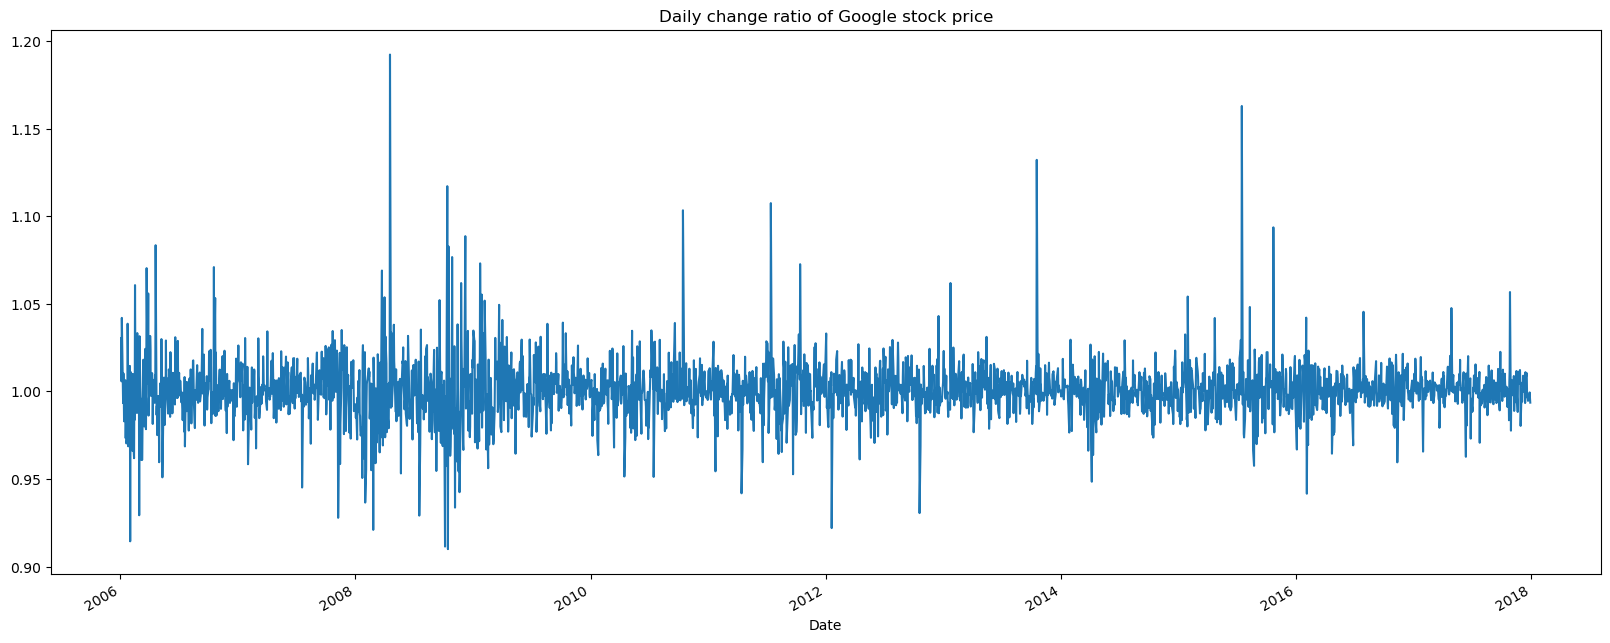

In [32]:
google['Change'].plot(figsize=(20,8))
plt.title('Daily change ratio of Google stock price')
plt.show()

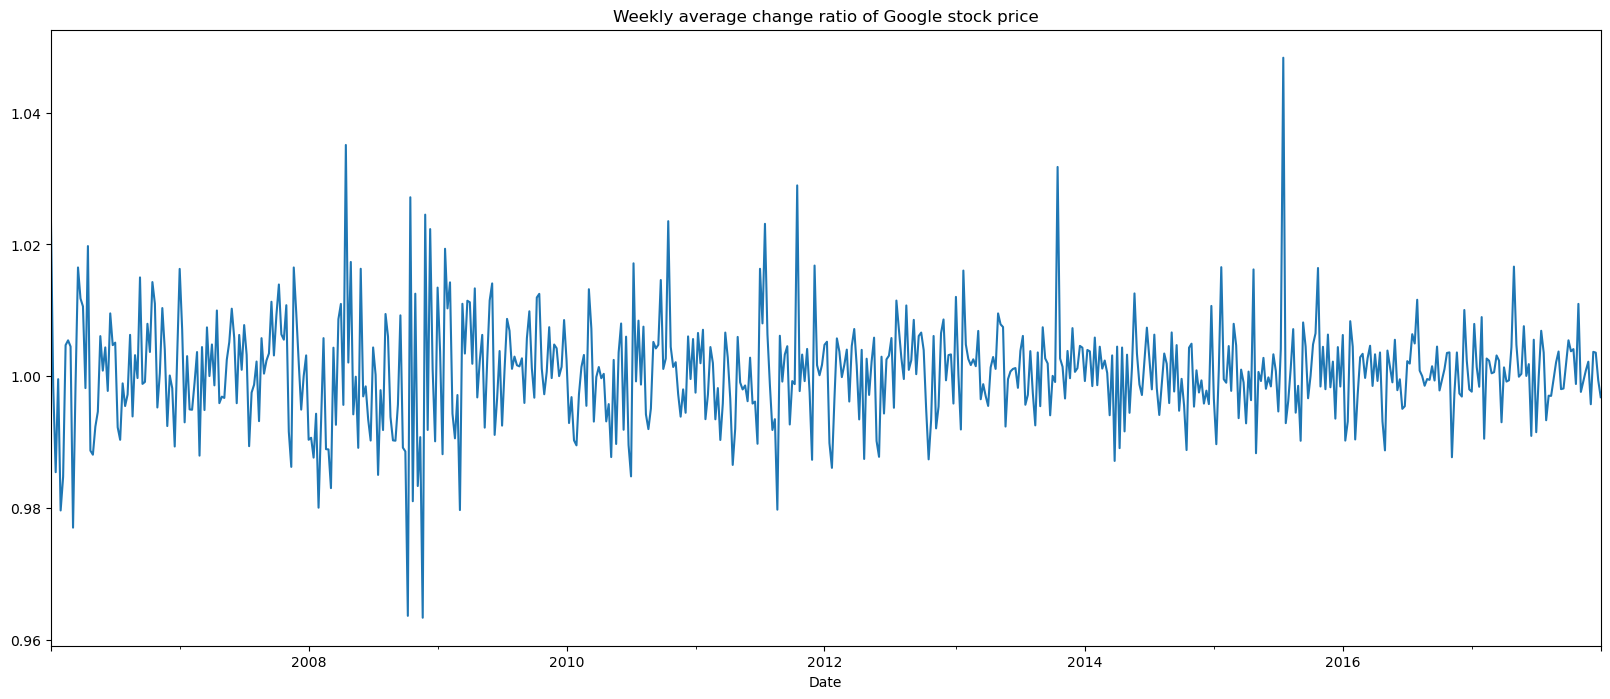

In [33]:
weekly_change = google['Change'].resample('W').mean()
weekly_change.plot(figsize=(20,8))

plt.title('Weekly average change ratio of Google stock price')
plt.show()

### Percentage Change

Text(0.5, 1.0, 'Daily percentage change of Google stock price')

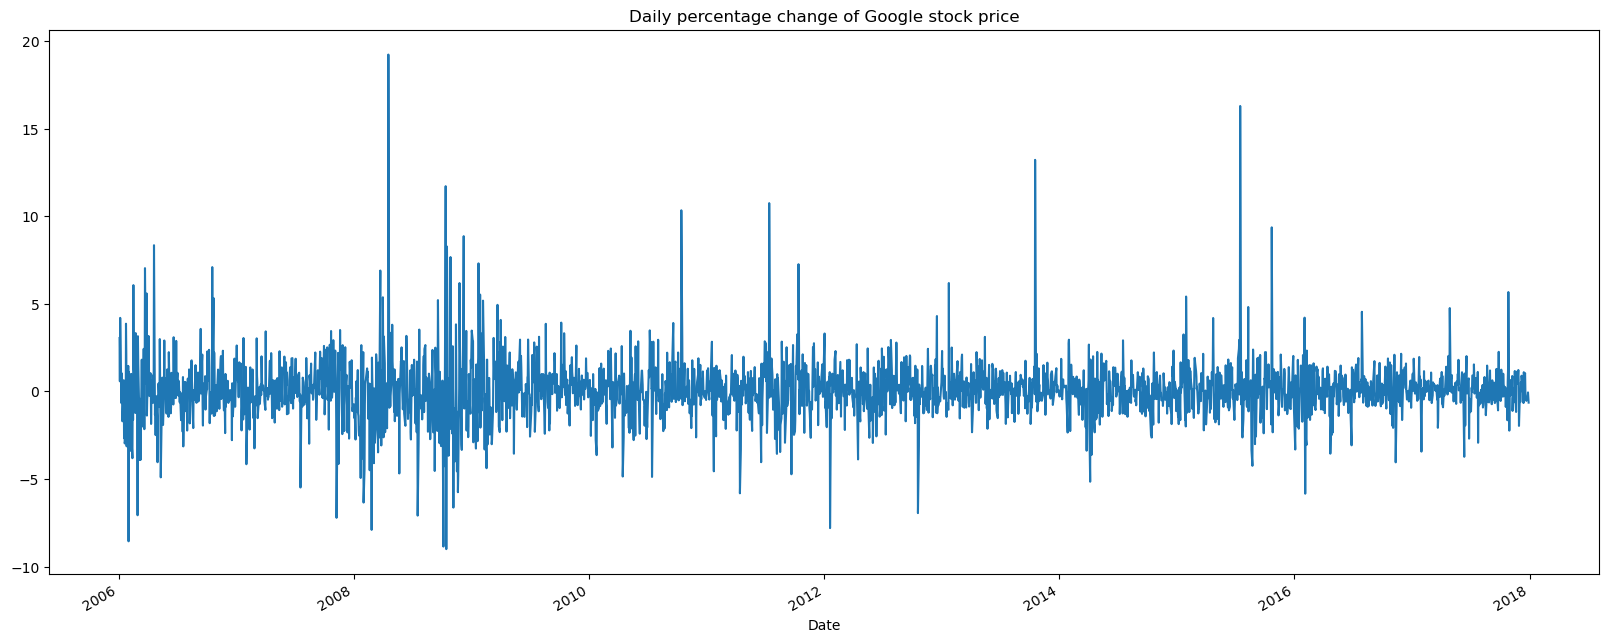

In [34]:
google['Return'] = google.Change.sub(1).mul(100)
google['Return'].plot(figsize=(20,8))

plt.title('Daily percentage change of Google stock price')

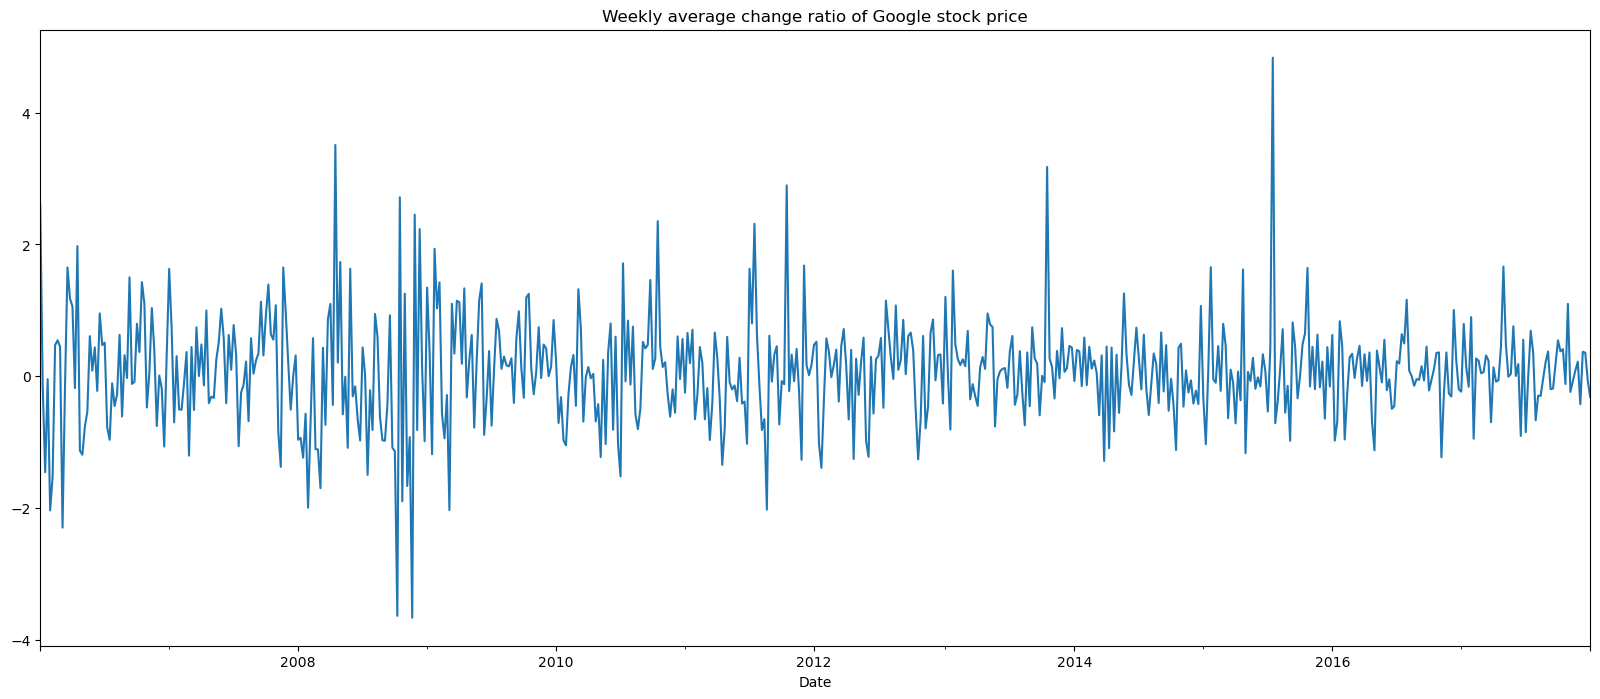

In [35]:
weekly_change = google['Change'].sub(1).mul(100).resample('W').mean()
weekly_change.plot(figsize=(20,8))

plt.title('Weekly average change ratio of Google stock price')
plt.show()

### Absolute Change

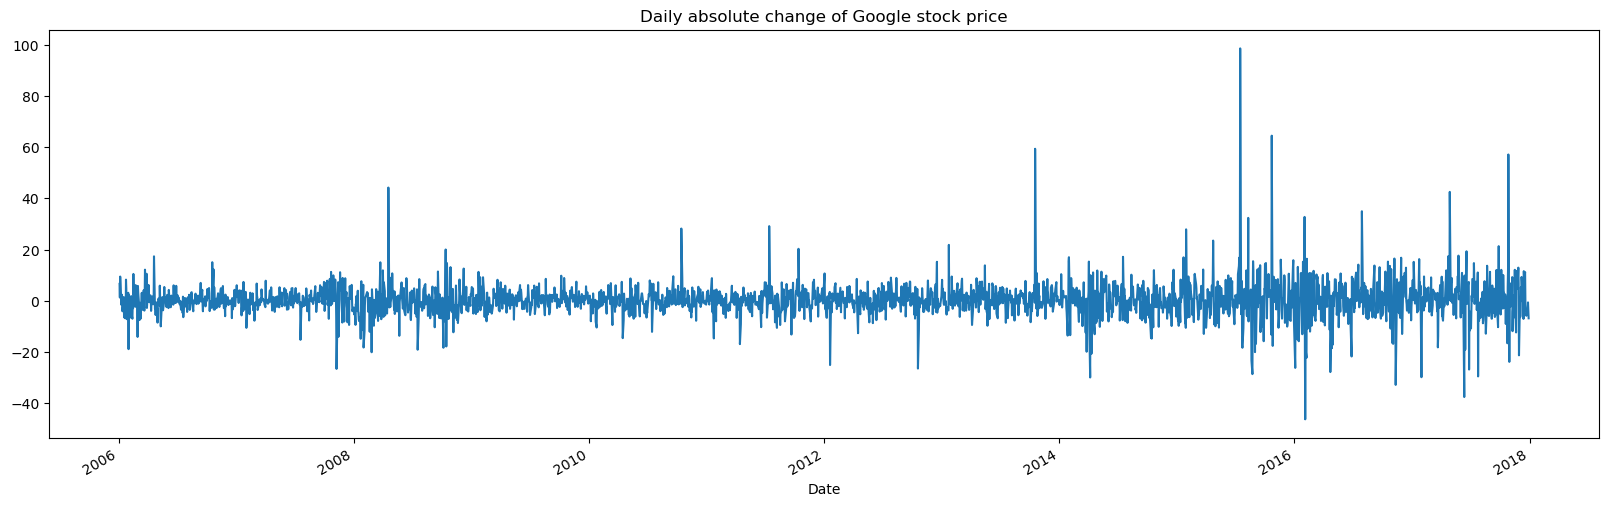

In [36]:
google.High.diff().plot(figsize=(20,6))

plt.title('Daily absolute change of Google stock price')
plt.show()

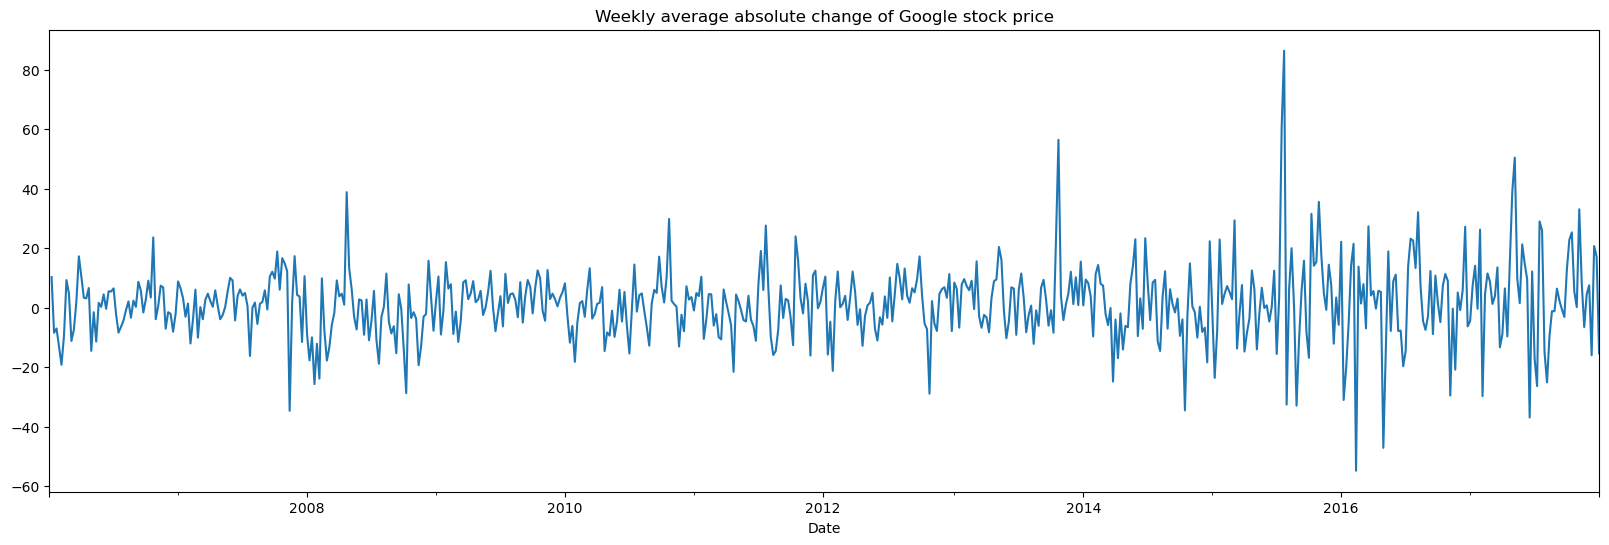

In [37]:
google['High'].resample('W').mean().diff().plot(figsize=(20,6))

plt.title('Weekly average absolute change of Google stock price')
plt.show()

## Comparing 2 or more time series

In [38]:
microsoft = pd.read_csv('Stock/MSFT_2006-01-01_to_2018-01-01.csv',
                        index_col='Date', parse_dates=['Date'])
microsoft.head()

Open   High    Low  Close     Volume  Name
Date                                                   
2006-01-03  26.25  27.00  26.10  26.84   79974418  MSFT
2006-01-04  26.77  27.08  26.77  26.97   57975661  MSFT
2006-01-05  26.96  27.13  26.91  26.99   48247610  MSFT
2006-01-06  26.89  27.00  26.49  26.91  100969092  MSFT
2006-01-09  26.93  27.07  26.76  26.86   55627836  MSFT

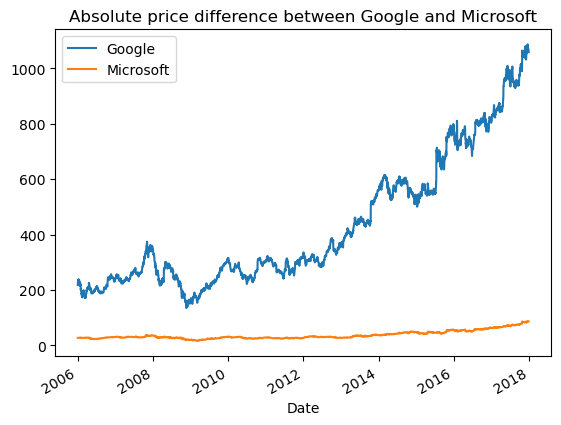

In [39]:
google.High.plot()
microsoft.High.plot()

plt.title('Absolute price difference between Google and Microsoft')
plt.legend(['Google','Microsoft'])
plt.show()

Not that direct to see the difference because of different starting price

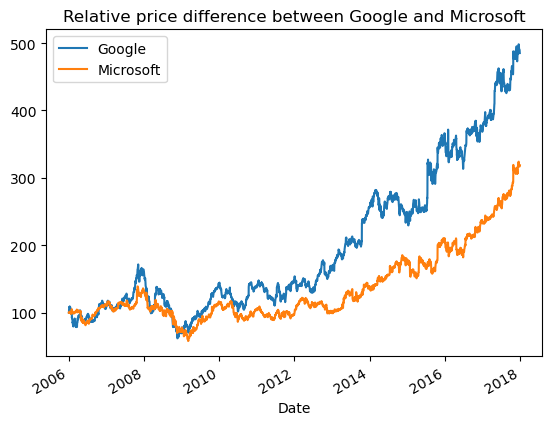

In [40]:
normalized_google = google.High.div(google.High.iloc[0]).mul(100)
normalized_microsoft = microsoft.High.div(microsoft.High.iloc[0]).mul(100)

normalized_google.plot()
normalized_microsoft.plot()

plt.title('Relative price difference between Google and Microsoft')
plt.legend(['Google','Microsoft'])
plt.show()

## Window functions

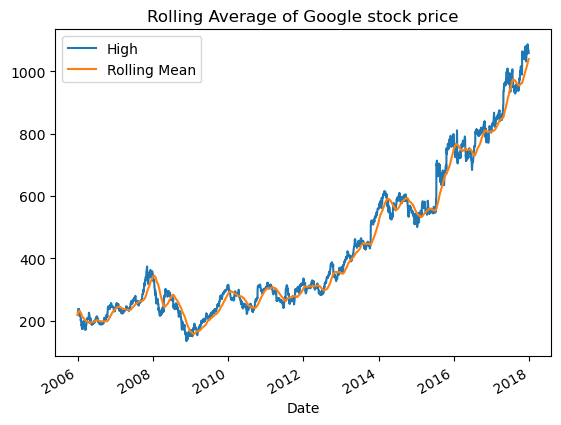

In [41]:
rolling_google = google.High.rolling('90D').mean()

google.High.plot()
rolling_google.plot()

plt.title('Rolling Average of Google stock price')
plt.legend(['High','Rolling Mean'])
plt.show()

### Expanding accumulate all past data when doing smoothing

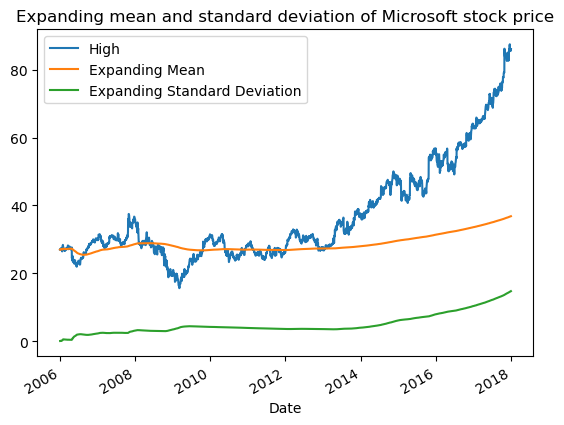

In [42]:
microsoft_mean = microsoft.High.expanding().mean() # smooth data
microsoft_std = microsoft.High.expanding().std() # show deviation from mean

microsoft.High.plot()
microsoft_mean.plot()
microsoft_std.plot()

plt.title('Expanding mean and standard deviation of Microsoft stock price')
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

## OHLC charts

In [43]:
google.head()

Open    High     Low   Close    Volume   Name    Change  \
Date                                                                    
2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL       NaN   
2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL  1.030498   
2006-01-05  223.22  226.00  220.97  225.85  10815661  GOOGL  1.005785   
2006-01-06  228.66  235.49  226.85  233.06  17759521  GOOGL  1.041991   
2006-01-09  233.44  236.94  230.70  233.68  12795837  GOOGL  1.006157   

              Return  
Date                  
2006-01-03       NaN  
2006-01-04  3.049759  
2006-01-05  0.578549  
2006-01-06  4.199115  
2006-01-09  0.615737

In [44]:
june_2008 = google[(google.index >= '2008-06-01') & (google.index <= '2008-06-30')]

trace = go.Ohlc(x = june_2008.index,
                open = june_2008.Open,
                high = june_2008.High,
                low = june_2008.Low,
                close = june_2008.Close)

plot = go.Figure(data = trace)
plot.update_layout(title = 'OHLC Chart of Google for June 2008',
                   xaxis_title = 'Date', yaxis_title = 'Price')
plot.show()

In [45]:
year_2008 = google.iloc[google.index.year == 2008]

trace = go.Ohlc(x = year_2008.index,
                open = year_2008.Open,
                high = year_2008.High,
                low = year_2008.Low,
                close = year_2008.Close)

plot = go.Figure(data = trace)
plot.update_layout(title = 'OHLC Chart of Google for 2008',
                   xaxis_title = 'Date', yaxis_title = 'Price')
plot.show()

In [46]:
trace = go.Ohlc(x = google.index,
                open = google.Open,
                high = google.High,
                low = google.Low,
                close = google.Close)

plot = go.Figure(data = trace)
plot.update_layout(title = 'OHLC Chart of Google',
                   xaxis_title = 'Date', yaxis_title = 'Price')
plot.show()

In [47]:
march_2008 = google[(google.index >= '2008-03-01') & (google.index <= '2008-03-31')]

trace = go.Candlestick(x = march_2008.index, 
                       open = march_2008.Open,
                       high = march_2008.High,
                       low = march_2008.Low,
                       close = march_2008.Close)

plot = go.Figure(data = trace)
plot.update_layout(title = 'Candlestick Chart of Google for March 2008',
                   xaxis_title = 'Date', yaxis_title = 'Price')
plot.show()

In [48]:
year_2008 = google.iloc[google.index.year == 2008]

trace = go.Candlestick(x = year_2008.index, 
                       open = year_2008.Open,
                       high = year_2008.High,
                       low = year_2008.Low,
                       close = year_2008.Close)

plot = go.Figure(data = trace)
plot.update_layout(title = 'Candlestick Chart of Google for 2008',
                   xaxis_title = 'Date', yaxis_title = 'Price')
plot.show()

In [49]:
trace = go.Candlestick(x = google.index, 
                       open = google.Open,
                       high = google.High,
                       low = google.Low,
                       close = google.Close)

plot = go.Figure(data = trace)
plot.update_layout(title = 'Candlestick Chart of Google',
                   xaxis_title = 'Date', yaxis_title = 'Price')
plot.show()

## Autocorrelation and Partial Autocorrelation

- Autocorrelation - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags. (It consider how all previous values impact the current value)

- Partial Autocorrelation - The partial autocorrelation function can be interpreted as a regression of the series against its past lags. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant. (It only consider how a section of previous values impact the current value) EXAMPLE: if you’re trying to see how the mood from three days ago impacts today, it removes the influence of the mood from one and two days ago

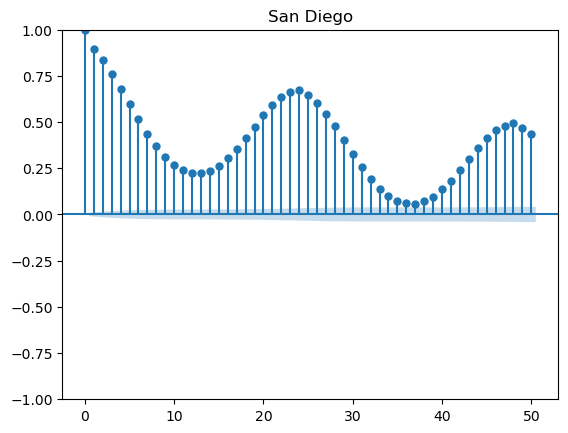

In [50]:
plot_acf(humidity["San Diego"], lags = 50, title = "San Diego")
plt.show()

The null hypothesis states that there is no autocorrelation in the data at a specific lag. When the autocorrelation value falls within the confidence interval, it suggests that the correlation is not statistically significant, supporting the null hypothesis.

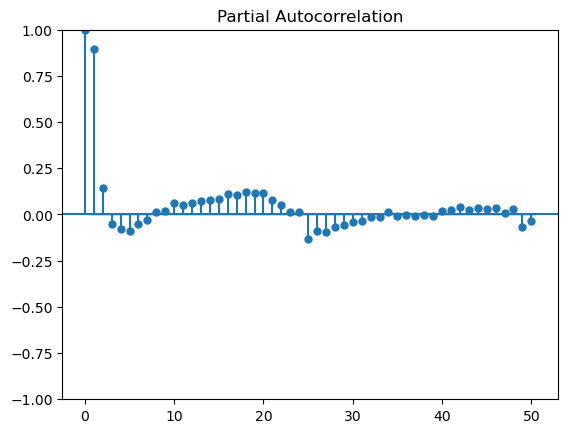

In [51]:
plot_pacf(humidity["San Diego"], lags = 50)
plt.show()

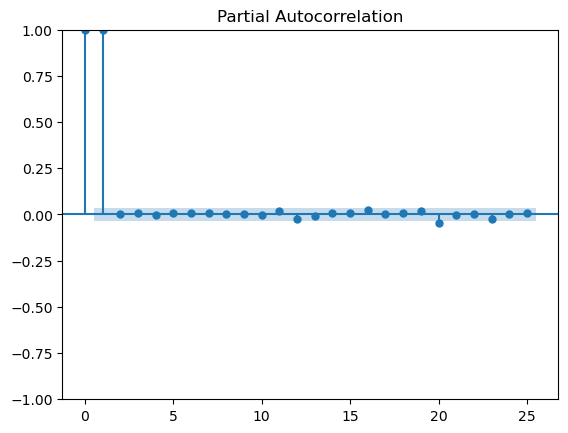

In [52]:
plot_pacf(microsoft["Close"], lags = 25)
plt.show()

## Time Series decomposition

### Trends, seasonality, and noise

* Trend - Consistent upwards or downwards slope of a time series
* Seasonality - Clear periodic pattern of a time series
* Noise - Outliers or missing values

<Axes: xlabel='Date'>

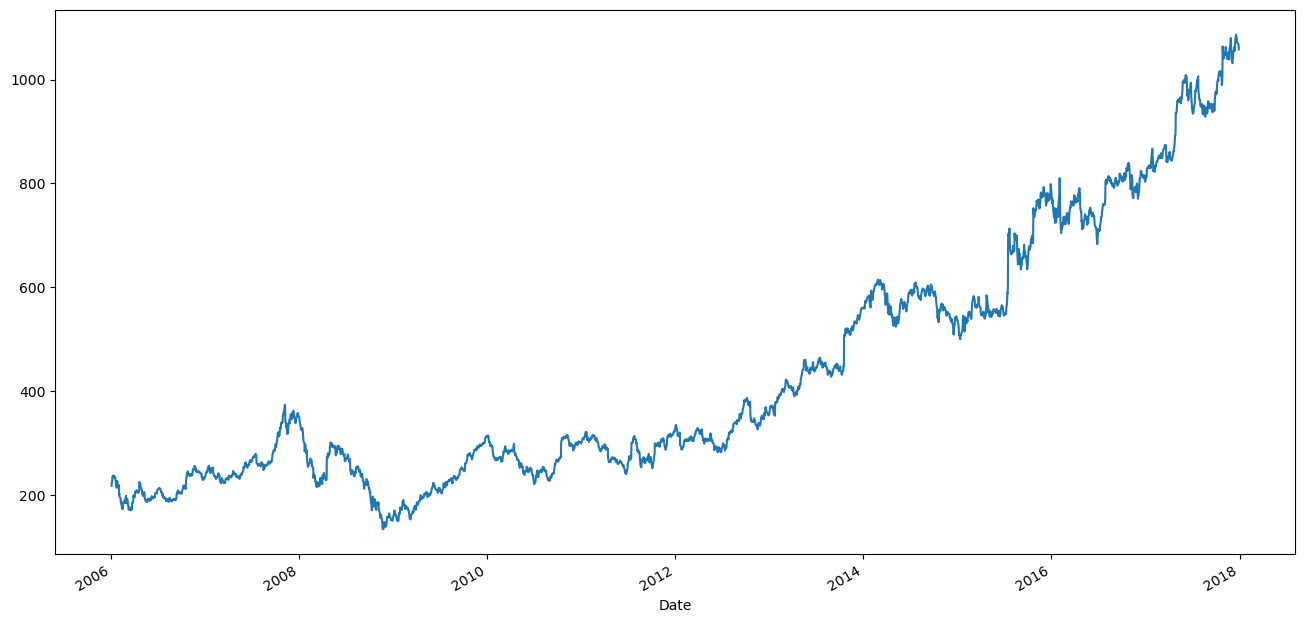

In [53]:
google["High"].plot(figsize=(16,8))

<Figure size 1000x1000 with 0 Axes>

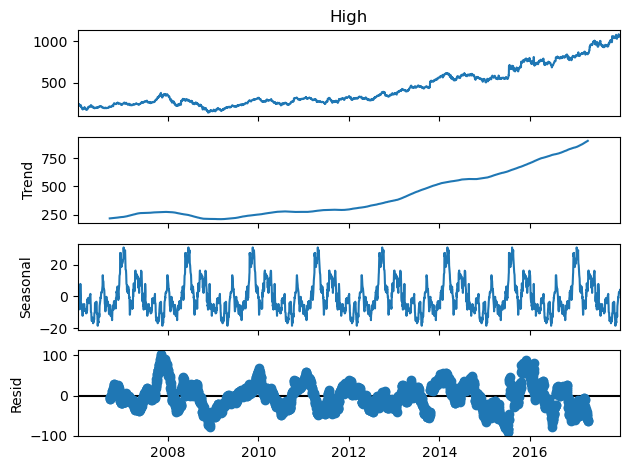

In [54]:
plt.figure(figsize=(10, 10))

decomposed_google_volume = sm.tsa.seasonal_decompose(google["High"], period=360)
figure = decomposed_google_volume.plot()
plt.show()

### White Noise

White noise has:

* Constant mean
* Constant variance
* Zero sutocorrelation at all lags

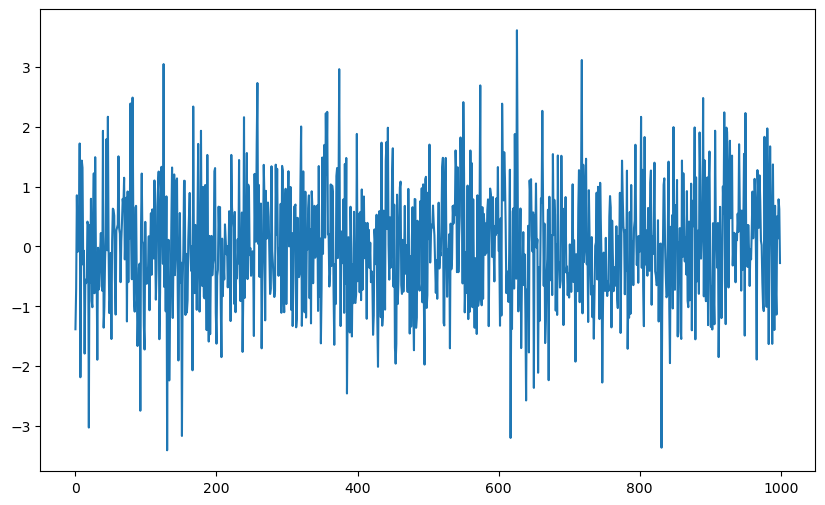

In [55]:
plt.figure(figsize=(10, 6))

white_noise = normal(loc=0, scale=1, size=1000)
# loc is mean, scale is variance
plt.plot(white_noise)

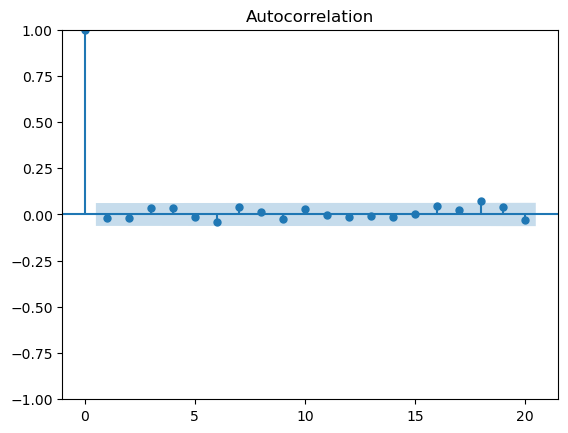

In [56]:
plot_acf(white_noise, lags = 20)
plt.show()

### Random Walk

A random walk is a mathematical object, known as a stochastic or random process, that describes a path that consists of a succession of random steps on some mathematical space such as the integers.

In general if we talk about stocks, Today's Price = Yesterday's Price + Noise

### $ P_t = P_{t-1} + \epsilon_t $

Random walks can't be forecasted because noise is random.

Random Walk with Drift(drift(μ) is zero-mean

Drift refers to the constant component in a random walk with drift, representing the average direction or trend over time. It’s like the slight uphill or downhill slope on a walk, guiding the overall direction despite the random steps.

### $ P_t - P_{t-1} = \mu + \epsilon_t $

Regression test for random walk

### $ P_t = \alpha + \beta P_{t-1} + \epsilon_t$
<br/><br/>
**if:**
#### $ P_t - P_{t-1} = \alpha + \beta P_{t-1} + \epsilon_t - P_{t-1}$
then
#### $ P_t - P_{t-1} = \alpha + (\beta-1) P_{t-1} + \epsilon_t$

**when $\beta = 1$:**
#### $ P_t - P_{t-1} = \alpha + (1-1) P_{t-1} + \epsilon_t$
#### $ P_t - P_{t-1} = \mu + \epsilon_t$

Test:

#### $H_0: \beta = 1$ (This is a random walk)
#### $H_1: \beta < 1$ (This is not a random walk)

Dickey-Fuller Test:

#### $H_0: \beta = 0$ (This is a random walk)
#### $H_1: \beta < 0$ (This is not a random walk)

### Augmented Dickey-Fuller test

An augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. It is basically Dickey-Fuller test with more lagged changes on RHS.

In [57]:
adf = adfuller(microsoft["Volume"])
print("p-value of microsoft: {}".format(float(adf[1])))
adf = adfuller(google["Volume"])
print("p-value of google: {}".format(float(adf[1])))

p-value of microsoft: 0.0003201525277652083
p-value of google: 6.510719605768119e-07


As microsoft has p-value 0.0003201525 which is less than 0.05, null hypothesis is rejected and this is not a random walk.

Now google has p-value 0.0000006510 which is less than 0.05, null hypothesis is rejected and this is not a random walk.

**Generating a random walk**

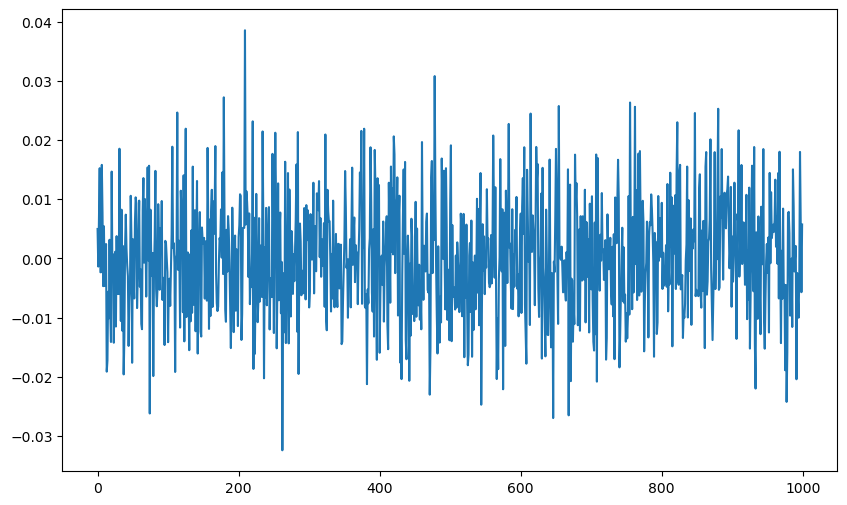

In [58]:
seed(42)

plt.figure(figsize=(10, 6))
random_walk = normal(loc=0, scale=0.01, size=1000)
plt.plot(random_walk)
plt.show()

In [59]:
fig = ff.create_distplot([random_walk], ['Random Walk'], bin_size = 0.001)
iplot(fig, filename = 'Basic Distplot')

### Stationarity

A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.

* Strong stationarity: is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time.

* Weak stationarity: is a process where mean, variance, autocorrelation are constant throughout the time.

Stationarity is important as non-stationary series that depend on time have too many parameters to account for when modelling the time series. diff() method can easily convert a non-stationary series to a stationary series.

<Axes: xlabel='Date'>

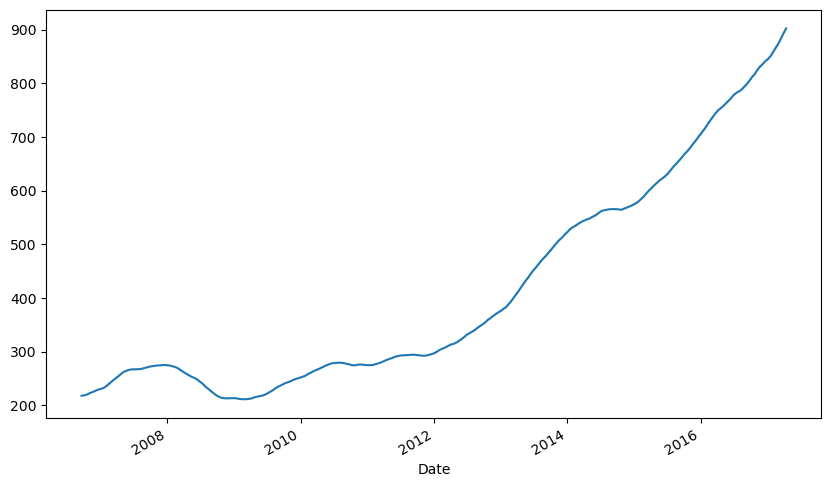

In [60]:
plt.figure(figsize=(10, 6))
decomposed_google_volume.trend.plot()

<Axes: xlabel='Date'>

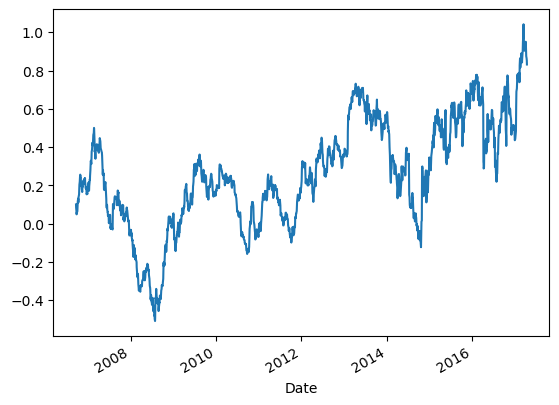

In [61]:
decomposed_google_volume.trend.diff().plot()

## Modelling

### AR models

An autoregressive (AR) model is a representation of a type of random process; as such, it is used to describe certain time-varying processes in nature, economics, etc. The autoregressive model specifies that the output variable depends **linearly** on its own previous values and on a stochastic term (**Error**: an imperfectly predictable term);

**AR(1) model**

$R_t =\mu + \phi R_{t-1} + \epsilon_t $

As RHS has only one lagged value($R_{t-1}$)this is called AR model of order **1** where $\mu$ is mean and $\epsilon$ is noise at time $t$

If $\phi = 1$, it is random walk: This means the series doesn't revert to a mean and has a persistent effect.

Else if $\phi = 0$, it is white noise: This indicates no autocorrelation; each value is independent of others.

Else if $-1 < \phi < 1$, it is stationary: This means the series reverts to a mean, with finite variance.

If $\phi$ is -ve, there is mean reversion: The negative autoregressive parameter (ϕ) means that if the current value is above the mean, the next value tends to be below the mean, and vice versa.When ϕ is negative, each value tends to counteract the previous one, effectively 'correcting' deviations and thus reverting to the mean.

If $\phi$ is +ve, there is momentum.

**AR(2) model**

$R_t =\mu + \phi_1 R_{t-1} + \phi_2 R_{t-2} + \epsilon_t $

Positive AR Parameter: Each value is positively correlated with its previous value. This leads to a series where if one value is high, the next tends to be high too.

Negative AR Parameter: Effect: Each value is negatively correlated with its previous value. If one value is high, the next tends to be low, creating an oscillating pattern.

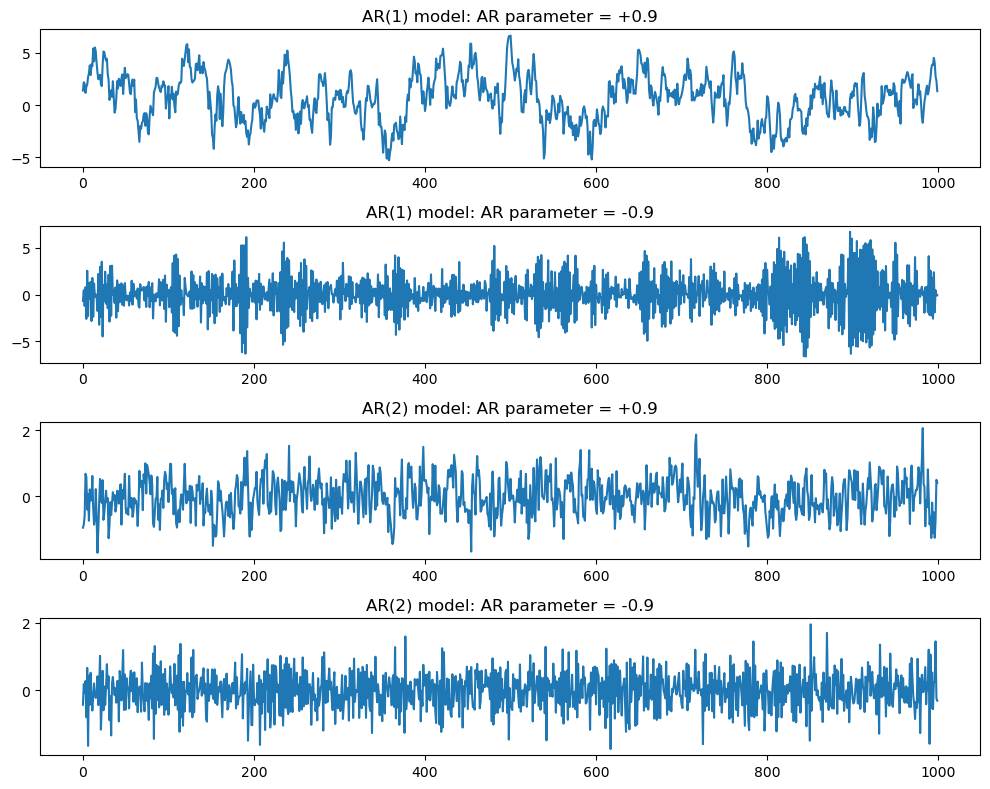

In [62]:
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

# [1, x]: current value depends on previous value
# [2, x]: current value depends on past 2 values

ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1]) # Moving Average
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
axs[0].set_title('AR(1) model: AR parameter = +0.9')
axs[0].plot(sim1)

ar2 = np.array([1, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
axs[1].set_title('AR(1) model: AR parameter = -0.9')
axs[1].plot(sim2)

ar3 = np.array([2, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
axs[2].set_title('AR(2) model: AR parameter = +0.9')
axs[2].plot(sim3)

ar4 = np.array([2, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
axs[3].set_title('AR(2) model: AR parameter = -0.9')
axs[3].plot(sim4)

plt.tight_layout()
plt.show()

## Predict simulated model

In [63]:
model = ARIMA(sim1, order=(1, 0, 0))
result = model.fit()

print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0], result.params[1]))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1415.701
Date:                Mon, 28 Oct 2024   AIC                           2837.403
Time:                        14:47:08   BIC                           2852.126
Sample:                             0   HQIC                          2842.998
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7072      0.293      2.417      0.016       0.134       1.281
ar.L1          0.8916      0.015     60.958      0.000       0.863       0.920
sigma2         0.9920      0.044     22.667      0.0

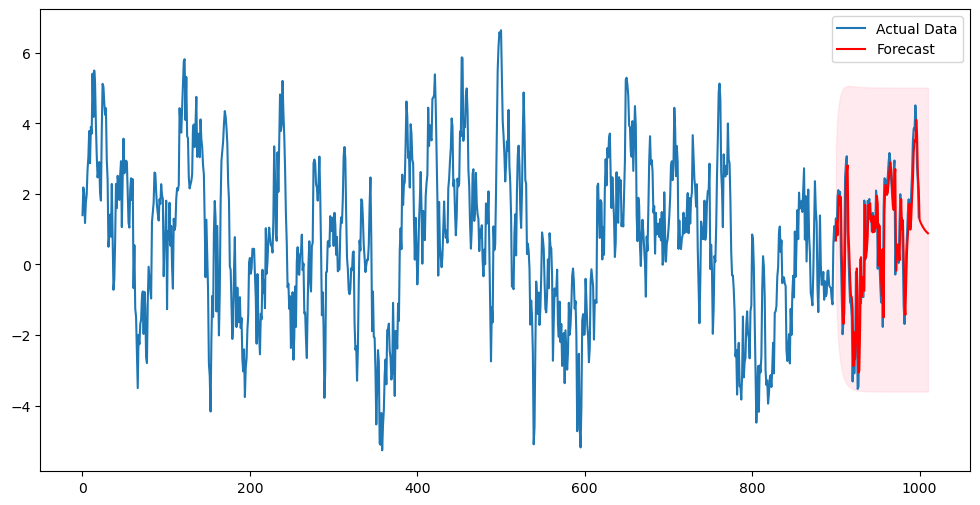

In [64]:
predict_start = 900
predict_end = 1010
forecast = result.predict(start=900, end=1010)

plt.figure(figsize=(12, 6))
plt.plot(sim1, label='Actual Data')

forecast_index = np.arange(predict_start, predict_end + 1)
plt.plot(forecast_index, forecast, label='Forecast', color='red')

confidence_intervals = result.get_forecast(steps=(predict_end - predict_start)+1).conf_int()
plt.fill_between(forecast_index, confidence_intervals[:, 0], confidence_intervals[:, 1], color='pink', alpha=0.3)

# confidence_intervals[:, 0] = lower bound
# confidence_intervals[:, 1] = upper bound

plt.legend()
plt.show()

In [65]:
rmse = math.sqrt(mean_squared_error(sim1[900:1011], result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1.0408056511726917.


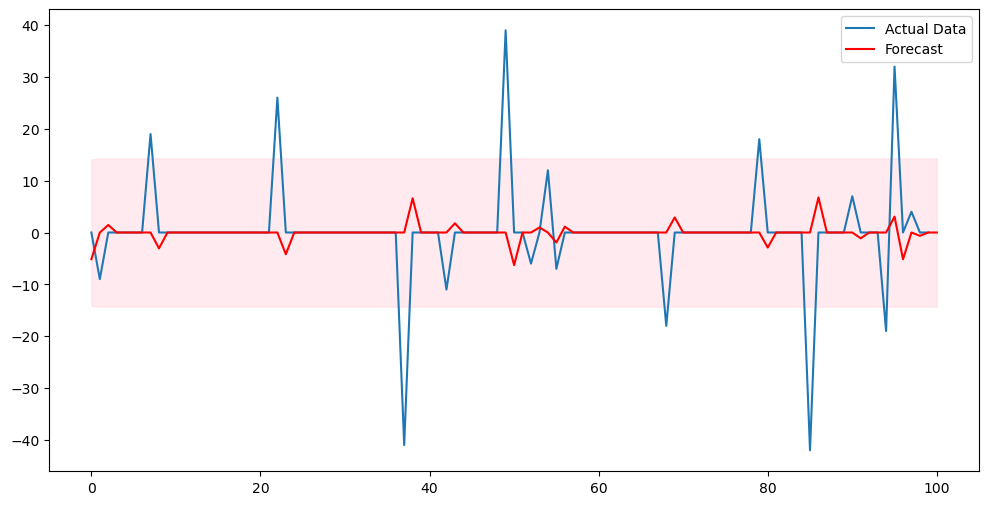

In [66]:
montreal_humidity = humidity["Montreal"].diff().iloc[1:].values

humid = ARIMA(montreal_humidity, order=(1, 0, 0))
res = humid.fit()

predict_start = 1000
predict_end = 1100
forecast = res.predict(start=predict_start, end=predict_end)

plt.figure(figsize=(12, 6))
plt.plot(montreal_humidity[predict_start:predict_end], label='Actual Data')

plt.plot(forecast, label='Forecast', color='red')

confidence_intervals = res.get_forecast(steps=(predict_end - predict_start)+1).conf_int()
plt.fill_between(np.arange(0, 101), confidence_intervals[:, 0], confidence_intervals[:, 1], color='pink', alpha=0.3)

plt.legend()
plt.show()

In [67]:
rmse = math.sqrt(mean_squared_error(montreal_humidity[900:1000], res.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 7.476556612264922.


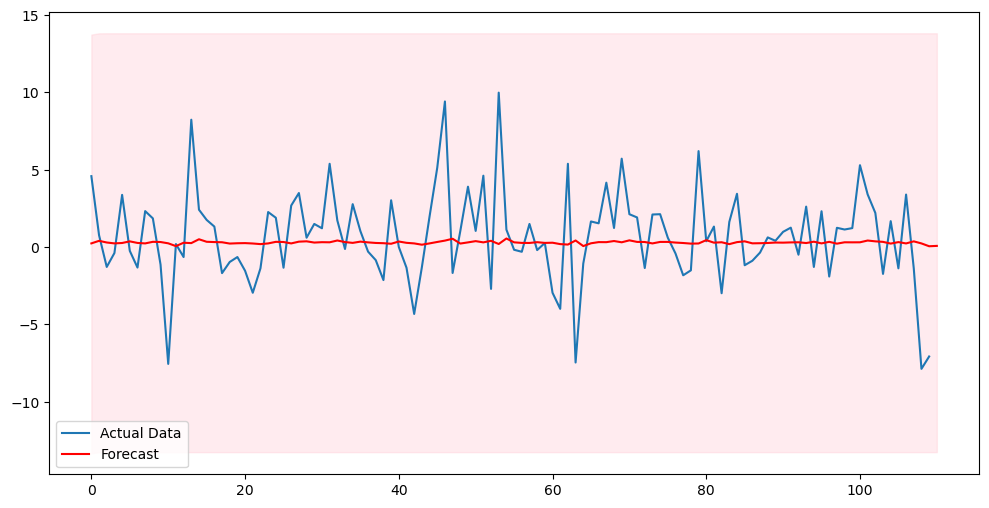

In [68]:
google_closing = google["Close"].diff().iloc[1:].values

price = ARIMA(google_closing, order=(1, 0, 0))
result = price.fit()

predict_start = 900
predict_end = 1010
forecast = result.predict(start=predict_start, end=predict_end)

plt.figure(figsize=(12, 6))
plt.plot(google_closing[predict_start:predict_end], label='Actual Data')

plt.plot(forecast, label='Forecast', color='red')

confidence_intervals = result.get_forecast(steps=(predict_end - predict_start)+1).conf_int()
plt.fill_between(np.arange(0, 111), confidence_intervals[:, 0], confidence_intervals[:, 1], color='pink', alpha=0.3)

plt.legend()
plt.show()

### MA models

The moving-average (MA) model is a common approach for modeling univariate time series. The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.

**MA(1) model**

$R_t =\mu + \epsilon_t + \theta \epsilon_{t-1}$

It translates to Today's returns = mean + today's noise + yesterday's noise

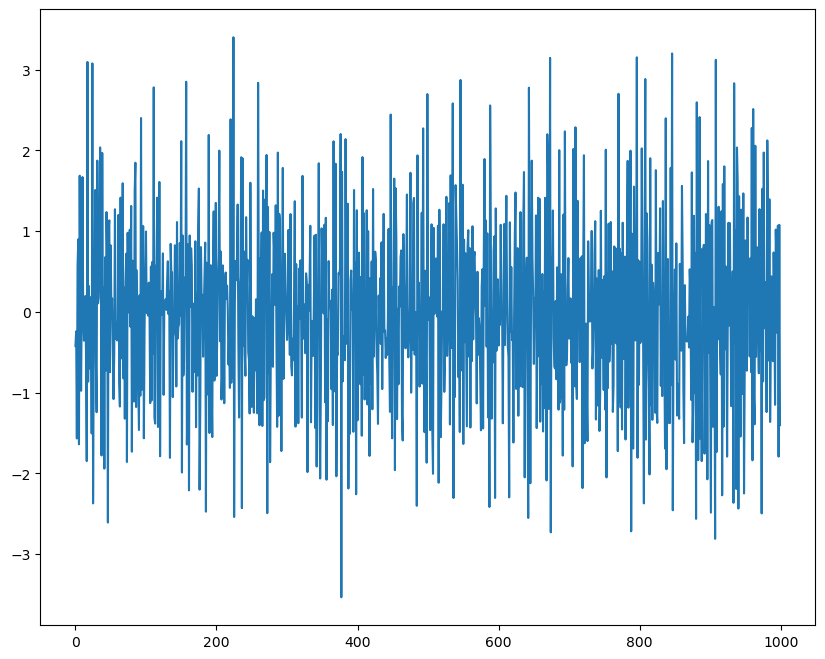

In [69]:
fig, axs = plt.subplots(figsize=(10, 8))

# [1, x]: degree of impact of today's noise (2 = double the impact)
# [x, 0.5]: positive influence from yesterday's noise

ar1 = np.array([1])
ma1 = np.array([1, -0.5]) # Moving Average
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=1000)

axs.plot(sim1)

In [70]:
model = ARIMA(sim1, order=(0, 0, 1))
result = model.fit()

print(result.summary())
print("μ={} ,θ={}".format(result.params[0], result.params[1]))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1423.276
Date:                Mon, 28 Oct 2024   AIC                           2852.553
Time:                        14:47:08   BIC                           2867.276
Sample:                             0   HQIC                          2858.148
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0229      0.014     -1.649      0.099      -0.050       0.004
ma.L1         -0.5650      0.027    -21.224      0.000      -0.617      -0.513
sigma2         1.0083      0.044     22.735      0.0

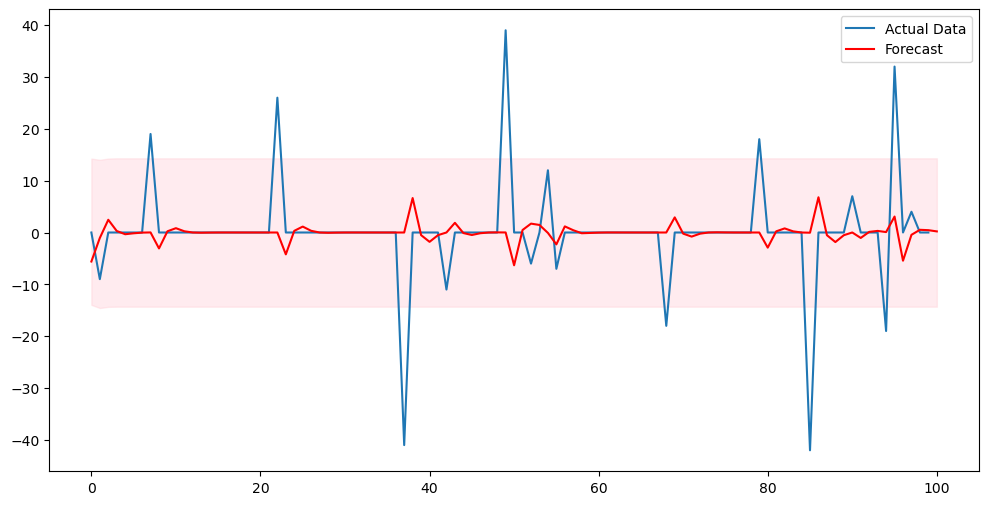

In [71]:
montreal_humidity = humidity["Montreal"].diff().iloc[1:].values

humid = ARIMA(montreal_humidity, order=(0, 0, 3))
res = humid.fit()

predict_start = 1000
predict_end = 1100
forecast = res.predict(start=predict_start, end=predict_end)

plt.figure(figsize=(12, 6))
plt.plot(montreal_humidity[predict_start:predict_end], label='Actual Data')

plt.plot(forecast, label='Forecast', color='red')

confidence_intervals = res.get_forecast(steps=(predict_end - predict_start)+1).conf_int()
plt.fill_between(np.arange(0, 101), confidence_intervals[:, 0], confidence_intervals[:, 1], color='pink', alpha=0.3)

plt.legend()
plt.show()

In [72]:
rmse = math.sqrt(mean_squared_error(montreal_humidity[900:1000], res.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 7.516834653469524.


### ARMA models

Autoregressive–moving-average (ARMA) models provide a parsimonious description of a (weakly) stationary stochastic process in terms of two polynomials, one for the autoregression and the second for the moving average. It's the fusion of AR and MA models.

**ARMA(1, 1) model**

$R_t =\mu + \phi R_{t-1} + \epsilon_t + \theta \epsilon_{t-1}$

Today's return = mean + Yesterday's return + noise + yesterday's noise.

In [73]:
microsoft_volume = microsoft['Volume'].diff().iloc[1:].values

volume = ARIMA(microsoft_volume, order=(3, 0, 3))
result = volume.fit()

print(result.summary())
print("μ={} ,θ={}".format(result.params[0], result.params[1]))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3018
Model:                 ARIMA(3, 0, 3)   Log Likelihood              -55411.375
Date:                Mon, 28 Oct 2024   AIC                         110838.751
Time:                        14:47:10   BIC                         110886.849
Sample:                             0   HQIC                        110856.046
                               - 3018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.03e+04   1.12e+04     -1.814      0.070   -4.22e+04    1631.176
ar.L1          0.0933      0.779      0.120      0.905      -1.433       1.619
ar.L2          0.8902      0.843      1.056      0.2

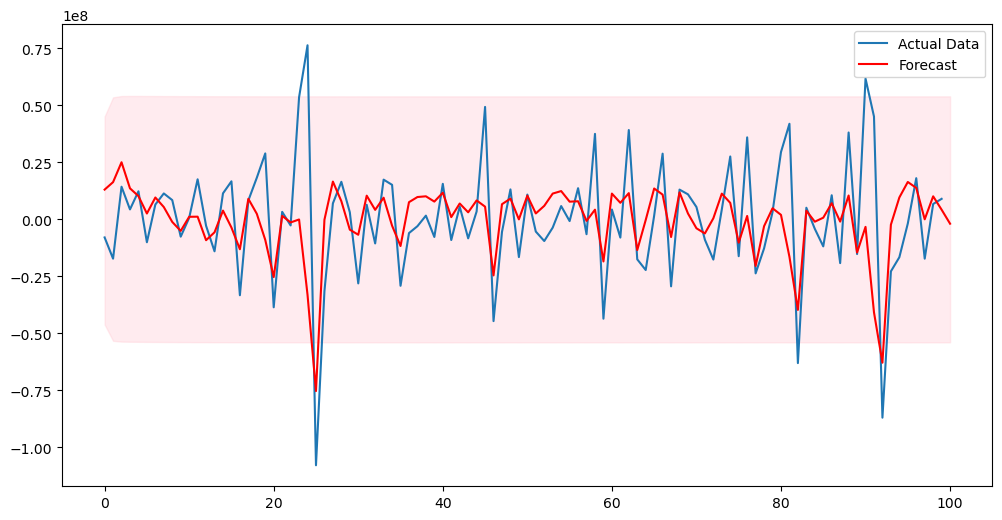

In [74]:
predict_start = 1000
predict_end = 1100
forecast = result.predict(start=predict_start, end=predict_end)

plt.figure(figsize=(12, 6))
plt.plot(microsoft_volume[predict_start:predict_end], label='Actual Data')

plt.plot(forecast, label='Forecast', color='red')

confidence_intervals = result.get_forecast(steps=(predict_end - predict_start)+1).conf_int()
plt.fill_between(np.arange(0, 101), confidence_intervals[:, 0], confidence_intervals[:, 1], color='pink', alpha=0.3)

plt.legend()
plt.show()

In [75]:
rmse = math.sqrt(mean_squared_error(microsoft_volume[1000:1101], res.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 26650839.10969188.


### ARIMA models

An autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity. ARIMA model is of the form: ARIMA(p,d,q): p is AR parameter, d is differential parameter, q is MA parameter.

**ARIMA(1, 0, 0)**

$R_t =\mu + \phi R_{t-1} + \epsilon_t $

**ARIMA(1, 0, 1)**

$R_t =\mu + \phi R_{t-1} + \epsilon_t + \theta \epsilon_{t-1}$

**ARIMA(1, 1, 1)**

$\Delta y_t = \phi \Delta y_{t-1} + \epsilon_t + \theta \epsilon_{t-1}$ where
$\Delta y_t = y_t - y_{t-1}$

In [76]:
microsoft_volume = microsoft['Volume'].iloc[1:].values

volume = ARIMA(microsoft_volume, order=(3, 1, 1))
result = volume.fit()

print(result.summary())
print("μ={} ,θ={}".format(result.params[0], result.params[1]))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3018
Model:                 ARIMA(3, 1, 1)   Log Likelihood              -55407.479
Date:                Mon, 28 Oct 2024   AIC                         110824.959
Time:                        14:47:11   BIC                         110855.019
Sample:                             0   HQIC                        110835.768
                               - 3018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3831      0.008     47.098      0.000       0.367       0.399
ar.L2          0.0796      0.019      4.290      0.000       0.043       0.116
ar.L3          0.0840      0.016      5.171      0.0

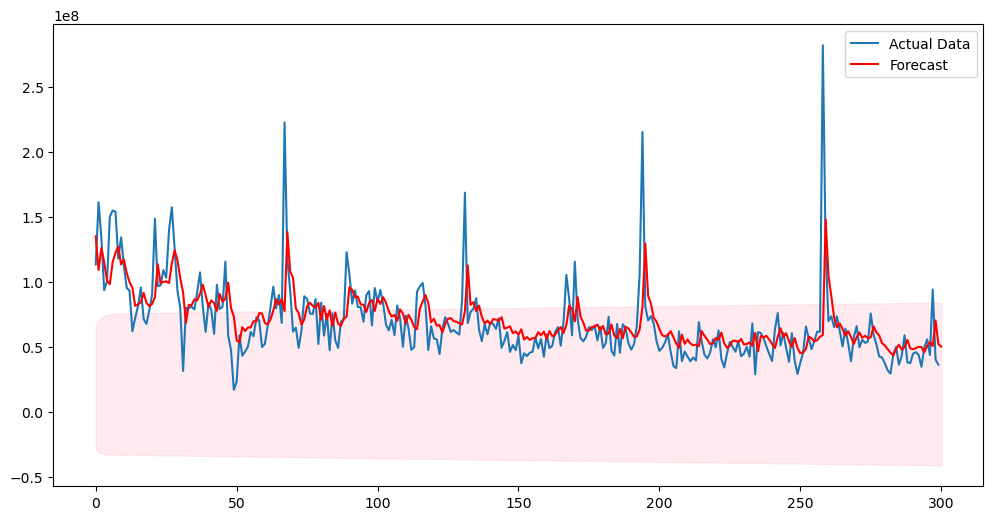

In [77]:
predict_start = 700
predict_end = 1000
forecast = result.predict(start=predict_start, end=predict_end)

plt.figure(figsize=(12, 6))
plt.plot(microsoft_volume[predict_start:predict_end], label='Actual Data')

plt.plot(forecast, label='Forecast', color='red')

confidence_intervals = result.get_forecast(steps=(predict_end - predict_start)+1).conf_int()
plt.fill_between(np.arange(0, 301), confidence_intervals[:, 0], confidence_intervals[:, 1], color='pink', alpha=0.3)

plt.legend()
plt.show()

In [78]:
rmse = math.sqrt(mean_squared_error(microsoft["Volume"].iloc[700:1001].values, result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 15801131.32785106.


### VAR models

Vector autoregression (VAR) is a stochastic process model used to capture the linear interdependencies among multiple time series. VAR models generalize the univariate autoregressive model (AR model) by allowing for more than one evolving variable. Each variable is a linear function of the past values (lags) of itself and the past values (lags) of all other variables in the system. This helps capture the interactions and mutual influences among the time series.

C:\Users\khais\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.

C:\Users\khais\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                           Statespace Model Results                           
Dep. Variable:     ['Close', 'Close']   No. Observations:                 3018
Model:                     VARMA(2,1)   Log Likelihood              -12185.173
                          + intercept   AIC                          24404.346
Date:                Mon, 28 Oct 2024   BIC                          24506.556
Time:                        14:47:13   HQIC                         24441.099
Sample:                             0                                         
                               - 3018                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.00, 0.00   Jarque-Bera (JB):   48239.30, 14929.09
Prob(Q):                        0.99, 1.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         3.32, 1.62   Skew:                      1.15, -0.03
Prob(H) (two-sided):            0.00,

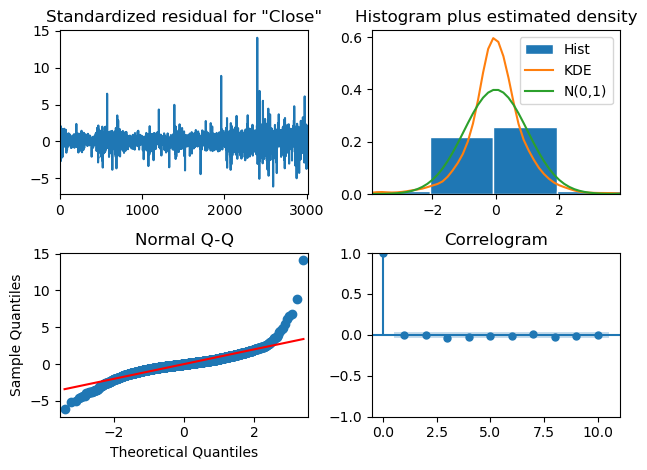

The root mean squared error is 3.674292210717789.


In [79]:
train_sample = pd.concat([google["Close"].diff().iloc[1:],
                          microsoft["Close"].diff().iloc[1:]],axis=1)

model = sm.tsa.VARMAX(train_sample,order=(2,1),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())

predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
plt.tight_layout()
plt.show()


# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

### SARIMA models

SARIMA models are useful for modeling seasonal time series, in which the mean and other statistics for a given season are not stationary across the years. The SARIMA model defined constitutes a straightforward extension of the nonseasonal autoregressive-moving average (ARMA) and autoregressive integrated moving average (ARIMA) models presented.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3018
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -10110.648
Date:                Mon, 28 Oct 2024   AIC                          20233.295
Time:                        15:04:49   BIC                          20269.369
Sample:                             0   HQIC                         20246.267
                               - 3018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3559      0.170      2.096      0.036       0.023       0.689
ar.L1          0.6415      0.039     16.515      0.000       0.565       0.718
ar.L2         -0.9268      0.038    -24.485      0.0

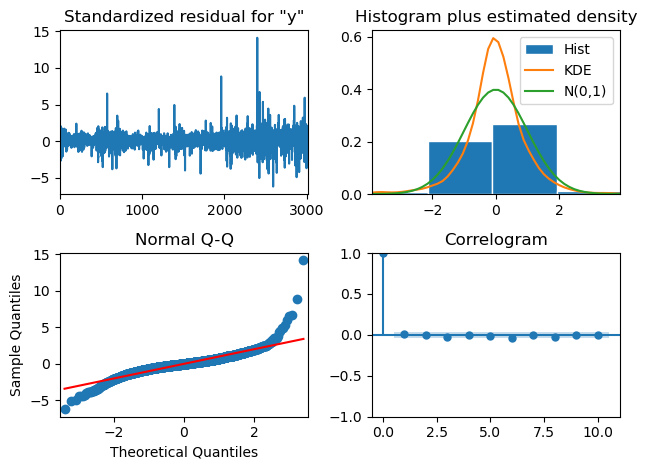

The root mean squared error is 4.396386895301674.


In [89]:
google_closing = google["Close"].diff().iloc[1:].values

model = sm.tsa.SARIMAX(google_closing, order = (2, 0, 2), trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())

predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
plt.tight_layout()
plt.show()

rmse = math.sqrt(mean_squared_error(google_closing[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

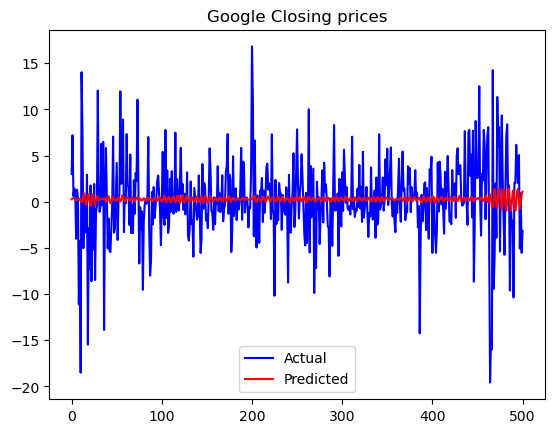

In [90]:
plt.plot(google_closing[1:502],color='blue')
plt.plot(predicted_result,color='red')
plt.legend(['Actual','Predicted'])
plt.title('Google Closing prices')
plt.show()

### Unobserved Components

Unobserved Components in time series analysis refer to the decomposable elements that make up the observed data, but are not directly observable themselves. Here are the main unobserved components:

- Trend: Long-term progression of the series. Captures the overall direction of the time series.
- Seasonal: Represents regular, repeating patterns within a fixed period.
- Cycle: Long-term fluctuations due to economic or business cycles. Different from seasonal components because the cycles aren’t fixed in length.
- Noise: random, unexplained variations in the time series. Captures the "noise" or random shocks that can't be attributed to the other components.

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                 3018
Model:                    local level   Log Likelihood              -10116.511
Date:                Mon, 28 Oct 2024   AIC                          20237.023
Time:                        15:53:53   BIC                          20249.047
Sample:                             0   HQIC                         20241.346
                               - 3018                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    47.7219      0.384    124.248      0.000      46.969      48.475
sigma2.level      5.033e-05      0.000      0.458      0.647      -0.000       0.000
Ljung-Box (L1) (Q):         

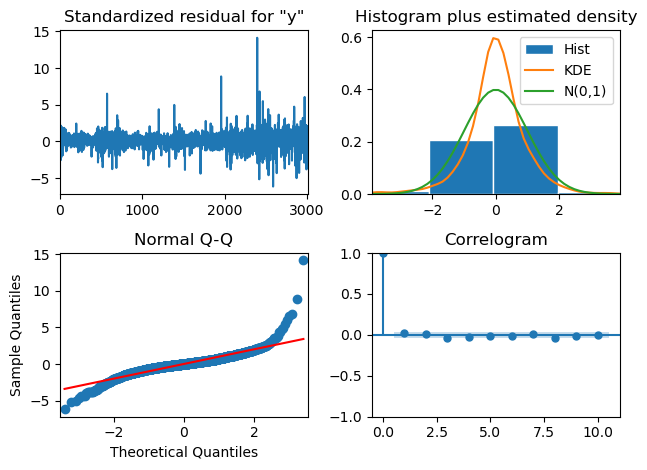

The root mean squared error is 4.412418985322885.


In [92]:
model = sm.tsa.UnobservedComponents(google_closing,'local level')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())

predicted_result = result.predict(start=0, end=500)
result.plot_diagnostics()
plt.tight_layout()
plt.show()

rmse = math.sqrt(mean_squared_error(google_closing[1:502], predicted_result))
print("The root mean squared error is {}.".format(rmse))

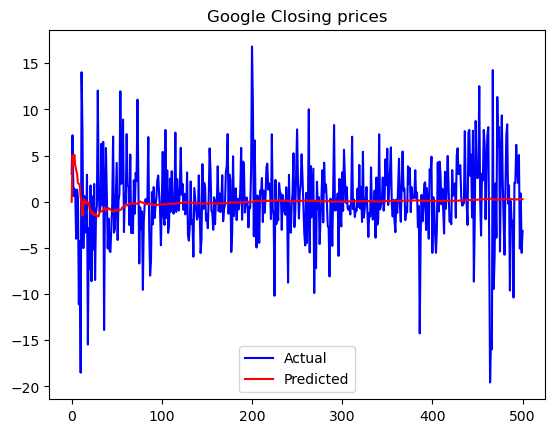

In [94]:
plt.plot(google_closing[1:502],color='blue')
plt.plot(predicted_result,color='red')
plt.legend(['Actual','Predicted'])
plt.title('Google Closing prices')
plt.show()